# Relativity Calculator

Relativity-calculator is a project to do some basic Lorentz factor calculations in universes with different fundamental constants. The [Lorentz factor](https://en.wikipedia.org/wiki/Lorentz_factor) describes the contraction in space or stretching in time for an object undergoing relativistic effects. We will arrive at an approximate equation for the Lorentz factor, then use numpy for calculations, and finally matplotlib and ipywidgets to create an interactive plot. 

*If you want to skip to the plot, scroll to the bottom.*

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive
import ipywidgets as widgets
import concurrent.futures

## Time Dilation

Relativisitic [time dilation](https://en.wikipedia.org/wiki/Time_dilation) occurs due to a number of effects that curve space-time: velocity, gravity, and, indirectly, the [cosmological constant](https://en.wikipedia.org/wiki/Cosmological_constant). The velocity portion iss easy to find, we will use the common Lorentz factor, but for the rest we will we need a solution to the Einstein Equations that includes gravity and the cosmological consant. 

### The Lorentz Factor

The [Lorentz factor](https://en.wikipedia.org/wiki/Lorentz_transformation) ($\gamma$) was initially formulated for a moving reference frame:  

$$ \gamma = \sqrt{1 - \frac{v^2}{c^2}} = \frac{dt}{d\tau} $$

Where:
- $v$ is the relative velocity between the observer and the moving frame.
- $c$ is the speed of light in a vacuum.
- $dt$ is the coordinate time (the observer)
- $d\tau$ is the proper time (the moving refernce frame)

So, to arrive at the time dilation from the perspective of the mover, we take the reciprical:

 $$ \frac{d\tau}{dt}  = \frac {1} {\sqrt{1 - \frac{v^2}{c^2}}} $$


### The Schwarzschild-de Sitter Metric

The [Schwarzschild-de Sitter metric](https://en.wikipedia.org/wiki/De_Sitter%E2%80%93Schwarzschild_metric) is a solution to Einstein's field equations that describes a non-rotating, spherically symmetric mass (like a planet or star) in a universe with a positive cosmological constant (Λ). 

The metric in this case is given by:

$$
ds^2 = -\left(1 - \frac{2GM}{rc^2} - \frac{\Lambda r^2}{3}\right)dt^2 + \frac{1}{\left(1 - \frac{2GM}{rc^2} - \frac{\Lambda r^2}{3}\right)} dr^2 + r^2 d\Omega^2
$$

where:
- ds is the infinitesimal spacetime interval,
- G is the gravitational constant,
- M is the mass of the object,
- r is the radial coordinate (distance from the center of the mass),
- c is the speed of light,
- t is the time coordinate,
- Λ is the cosmological constant, and
- dΩ² is the solid angle element (dθ² + sin²θdφ² in spherical coordinates).

The term (1 - 2GM/rc² - Λr²/3)dt² is the one that shows how time is affected by both gravity and the cosmological constant. 

If we consider a stationary observer (dr = dΩ = 0), the spacetime interval reduces to:

$$ds^2 = -\left(1 - \frac{2GM}{rc^2} - \frac{\Lambda r^2}{3}\right) dt^2$$

The proper time (dτ), which is the time experienced by a clock at rest in the gravitational field, is given by ds/c. So we have:

$$d\tau^2 = -\left(1 - \frac{2GM}{rc^2} - \frac{\Lambda r^2}{3}\right) dt^2$$

Taking the square root of both sides and rearranging gives the time dilation formula in a Schwarzschild-de Sitter spacetime:

$$\frac{d\tau}{dt} = \sqrt{1 - \frac{2GM}{rc^2} - \frac{\Lambda r^2}{3}}$$

This is the generalization of the gravitational time dilation formula to include the effects of a cosmological constant. It shows that a clock closer to a massive object (smaller r) or in a region of higher cosmological constant will run slower compared to a clock farther away or in a region of lower cosmological constant.

Since we will be considering the affect of c, we will not assume Λ is given in units of c. Substitute  Λ/c² for Λ:

$$\frac{d\tau}{dt} = \sqrt{1 - \frac{2GM}{rc^2} - \frac{\Lambda r^2}{3c^2}}$$

### Time Dilation Relative to Earth

I want to show the passive time relative to our normal reference frame (i.e. the surface of Earth, denoted with e subscript). We use a ratio of the above formula to get:

$$\frac{d\tau}{d\tau_e} = \frac{\sqrt{1 - \frac{2G_eM_e}{r_ec_e^2} - \frac{\Lambda_e r_e^2}{3c_e^2}}}{\sqrt{1 - \frac{2GM}{rc^2} - \frac{\Lambda r^2}{3c^2}}}$$

Since the cosmological constant is very small in our universe, we set it to 0 for the reference frame:

$$\frac{d\tau}{d\tau_e} = \frac{\sqrt{1 - \frac{2G_eM_e}{r_ec_e^2}}}{\sqrt{1 - \frac{2GM}{rc^2} - \frac{\Lambda r^2}{3c^2}}}$$

So that we can work entirely in parameters relative to Earth (subscript r), we substitute as below:

$$\frac{d\tau}{d\tau_e} = \frac{\sqrt{1 - \frac{2G_eM_e}{r_ec_e^2}}}{\sqrt{1 - \frac{2GM}{rc^2}(\frac{2G_eM_e}{r_ec_e^2}) - \frac{\Lambda r^2}{3c^2}}}$$

Finally, since the Earth parameters are constant, we can pre-calculate them and call that result K:

$$\frac{d\tau}{d\tau_e} = \frac{\sqrt{1 - K}}{\sqrt{1 - \frac{2GM}{rc^2}K - \frac{\Lambda r^2}{3c^2}}}$$

We can use this formula to show the relative passage of time on our hypothetical reference frame in comparison to Earth in our universe.

### Combined Equation
Lastly, we will multiply the equations for velocity and gravtiy together to arrive at a combined equation:

$$\frac{d\tau}{d\tau_e} = \frac{\sqrt{1 - K}}{\sqrt{1 - \frac{v^2}{c^2}}\sqrt{1 - \frac{2GM}{rc^2}K - \frac{\Lambda r^2}{3c^2}}}$$

Note there are a number of simplifications going into this formulation. For example, a point mass is assumed, there's no rotation, and it's not technically correct to just multiply them together since there is interaction between gravity and velocity. However, for the purposes of illustrating relativistic effects, we will see the correct trends and get reasonably accurate results for parameters near the Earth constants.

In [28]:
# Calculating the Earth Constant

Ge = 6.674E-11
Me = 5.972E24
re = 6.371E6
ce = 3.00E8
Le = 0

K = 2*Ge*Me/(re*(ce)**2)
print(f'K = {K}')

K = 1.3902275240237882e-09


Before defining the calculator functions, we need to decide on some upper and lower boundaries for the numerical approximation. These well help the chart look better by having something to show instead of #infinity or #undefined:

In [29]:
# small value to use instead of dividing by zero
epsilon = 1e-10
# large value to use instead of infinity
lmax = 1e6

In [30]:
def time_dilation(G,M,r,c,L): #parameters relative to earth
    np.seterr(divide='ignore', invalid='ignore') 
    c= np.where(c==0, epsilon, c)
    r= np.where(r==0, epsilon, r)
    denominator = 1- K*G*M/(r*c**2) + L*r**2/(3*c**2)
    denominator = np.where(denominator==0,epsilon, denominator)
    result = np.sqrt(1-K)/np.sqrt(denominator )
    return np.where(np.isnan(result),lmax,result)

### G-Force

We can define an effective gravitational force that would be felt by an observer in our hypothetical universe, and when it is expressed relative to the parameters of Earth, it is the [g-Force](https://en.wikipedia.org/wiki/G-force). We once again start with the Schwarzschild-de Sitter metric, and considering a test particle at rest (i.e., \(dr/dt = 0\)), the effective gravitational acceleration can be found by differentiating the metric with respect to r and setting the result equal to zero. This yields

$$ g = -c^2 \frac{d}{dr}\left(1 - \frac{2GM}{rc^2} - \frac{\Lambda r^2}{3}\right) $$

or, after some algebra,

$$ g = \frac{GM}{r^2} - \frac{1}{3}\Lambda c^2 r $$

Here, (G) is the gravitational constant, (M) is the mass of the object, (r) is the radial coordinate (distance from the center of the mass), (c) is the speed of light, and (Λ) is the cosmological constant.

This equation shows that the effective gravitational acceleration has two components: the familiar inverse square law term due to the mass of the object, and a term proportional to Λr due to the cosmological constant. Note that the Λ term becomes more significant at large distances, where it can lead to an effective "anti-gravity" effect (i.e., acceleration away from the mass). This is the phenomenon underlying the observed accelerated expansion of the universe.

In [31]:
def g_force(G,M,r,c,L): #the gravitational force at the given parameters, relative to earth
    np.seterr(divide='ignore', invalid='ignore') 
    r= np.where(r==0, epsilon, r)
    return G*M/r**2 - L*r*c**2/3

# Basis for the Chart (the x-axis)

Since the construction of our chart puts the current value alway in the middle of the chart, we can drastically speed up our computation by choosing a basis that is sparser further from zero. This way we can keep a good resolution around the current solution high. A histogram of the basis is also shown below.

(array([ 3.,  2.,  3.,  3.,  3.,  5.,  5.,  7., 11., 24., 68., 24., 11.,
         7.,  5.,  5.,  3.,  3.,  3.,  2.,  3.]),
 array([-100.        ,  -90.47619048,  -80.95238095,  -71.42857143,
         -61.9047619 ,  -52.38095238,  -42.85714286,  -33.33333333,
         -23.80952381,  -14.28571429,   -4.76190476,    4.76190476,
          14.28571429,   23.80952381,   33.33333333,   42.85714286,
          52.38095238,   61.9047619 ,   71.42857143,   80.95238095,
          90.47619048,  100.        ]),
 <BarContainer object of 21 artists>)

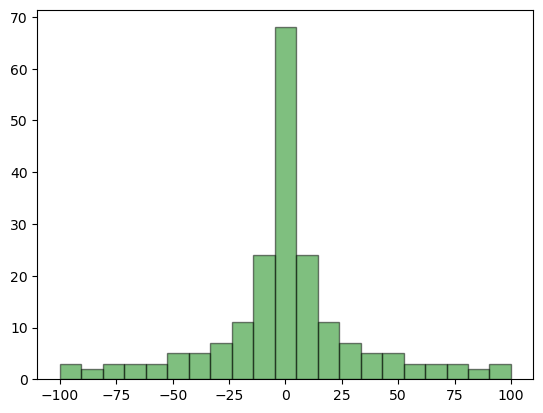

In [32]:
# chart basis (the x axis)
max_exp = 2
numberofpoints = 200
basis = np.concatenate([-np.flip(np.logspace(0,max_exp,numberofpoints//2)),np.logspace(0,max_exp,numberofpoints//2)])
plt.hist(basis, bins=21, alpha=0.5, color='g', edgecolor='black')

In [33]:
#define colors for plot
series_colors  = {'G': 'green', 'M': 'red', 'r': 'blue', 'c': 'orange', 'L': 'purple'}

In [34]:
# Define function to be executed in parallel
def process_param(param,p_dict):
    new_p = p_dict.copy()
    new_p[param] = p_dict[param] * basis
    return param, time_dilation(**new_p)


# using exponential scales
def p_plot(G,M,r,c,L,zoom):
    # Clear the current figure
    plt.clf()

    # create a dictionary for the parameters
    p_dict = {'G': G, 'M': M, 'r': r, 'c':c, 'L': L}
 #   p_dict_exp = {'G': 10**G, 'M': 10**M, 'r': 10**r, 'c':10**c, 'L':10**L}
    
    
    current_value= time_dilation(**p_dict)
    g = g_force(**p_dict)
  #  print(p_dict)
    print(f"Lorentz factor: {current_value}, g-force: {g}")

    # empty dictionary for results
    
    gammas = {}
    
    with concurrent.futures.ProcessPoolExecutor() as executor:
        # Submit the tasks to the executor
        futures = {executor.submit(process_param, param, p_dict): param for param in p_dict}

        # Collect the results as they become available
        for future in concurrent.futures.as_completed(futures):
            param = futures[future]
            try:
                result_param, result_value = future.result()
                gammas[result_param] = result_value
                plt.plot(basis, result_value, label=result_param, color=series_colors[result_param])
            except Exception as exc:
                print('%r generated an exception: %s' % (param, exc))
            
    # Plot current value
    plt.plot(0, current_value , 'ro')
    plt.annotate(np.round(current_value, 10), 
             (0,current_value),
             textcoords="offset points",  # how to position the text
             xytext=(-10,10),  # distance from text to points (x,y)
             ha='center',  # horizontal alignment can be left, right or center 
                )

    plt.xlabel('Parameter')
    plt.ylabel('Lorentz factor (gamma)')
    plt.legend()
    plt.ylim(0,10**zoom)
    plt.grid(True)
    plt.show()

In [35]:
# Create interactive plot using exponential parameters
interactive_plot = interactive(p_plot, 
    G= widgets.FloatLogSlider(value=1, base=10, min=-10, max=10, step=.01),
    M= widgets.FloatLogSlider(value=1, base=10, min=-5, max=5, step=.01),
    r= widgets.FloatLogSlider(value=1, base=10, min=-2, max=2, step=.01),
    c= widgets.FloatLogSlider(value=1, base=10, min=-6, max=6, step=.01),                                
    L= widgets.FloatLogSlider(value=0, base=10, min=-20, max=20, step=0.1),
    zoom = widgets.IntSlider(value=1, min=1, max=5, step=1, description='y scale'))
output = interactive_plot.children[-1]
output.layout.height = '800px'
interactive_plot

interactive(children=(FloatLogSlider(value=1.0, description='G', max=10.0, min=-10.0, step=0.01), FloatLogSlid…

## The Schwartzschield Radius and other Singularities